In [ ]:
# Load libraries
import numpy as np;
import pandas as pd
import io
import matplotlib.pyplot as plt
from timeit import default_timer

from sklearn.model_selection import train_test_split

# XGBOOST

## Intuition

- This type of model represents an ensemble (combination) of decision tree models.


- Each individual tree is trained sequentially.


- Each tree tries to correct the error of the previous ones.


- Its goal is to combine simple (shallow) trees with high bias and low variance (underfitting), and reduce its variance by combination.


- This type of ensemble methods is called **boosting**.

- It became known after its victory in a Kaggle competition about the Higgs Boson. https://www.kaggle.com/c/higgs-boson.


- Highly optimized --> scalable.


- XGBoost is an optimized version of the Gradient Boosting models.




## Data

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
X = pd.read_csv(io.BytesIO(uploaded['healthcare.csv']), sep = ";")
y = X['exitus']
X = X.drop(['exitus'], axis = 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
categorical_vars = set(['severity', 'origin', 'tip_adm', 'tip_grd', 'date'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)
ohe = OneHotEncoder(sparse_output = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names_out())
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)

In [ ]:
perc_values = [0.7, 0.15, 0.15];
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, stratify = y, test_size=perc_values[1] + perc_values[2], random_state=1);
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, stratify = y_valtest, test_size= perc_values[2] / (perc_values[1] + perc_values[2]), random_state=1)

# Early Stopping

In this case we have to go **outside scikit-learn** to apply XGBoost models.

In [ ]:
# [1] Import model
from xgboost import XGBClassifier as model_constructor

In [ ]:
# [2] Import metric
from sklearn.metrics import roc_auc_score as auc

In [ ]:
# [3] Define model
model = model_constructor(early_stopping_rounds = 10,
                      n_estimators = 1000,
                      eval_metric = "auc",
                      random_state = 1) # Default hyperparameters

To train the model we will use **early stopping**.

In [ ]:
# [4] Train model
model.fit(X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          verbose=True)

[0]	validation_0-auc:0.93022
[1]	validation_0-auc:0.93610
[2]	validation_0-auc:0.94377
[3]	validation_0-auc:0.94337
[4]	validation_0-auc:0.94567
[5]	validation_0-auc:0.94582
[6]	validation_0-auc:0.94504
[7]	validation_0-auc:0.94458
[8]	validation_0-auc:0.94439
[9]	validation_0-auc:0.94465
[10]	validation_0-auc:0.94488
[11]	validation_0-auc:0.94422
[12]	validation_0-auc:0.94414
[13]	validation_0-auc:0.94390
[14]	validation_0-auc:0.94418
[15]	validation_0-auc:0.94457


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [178]:
model.best_iteration

16

In [ ]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test)
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:,1]);
auc_val = auc(y_val, pred_val_p[:,1]);
auc_test = auc(y_test, pred_test_p[:,1]);
results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':['XGBoost - Default'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)
results

<ipython-input-159-09c32bb626be>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost - Default'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


,model,auc_train,auc_val,auc_test
0,XGBoost - Default,0.961665,0.945823,0.938858


# Calibrated Probabilities

Let's check if probabilites are calibrated.

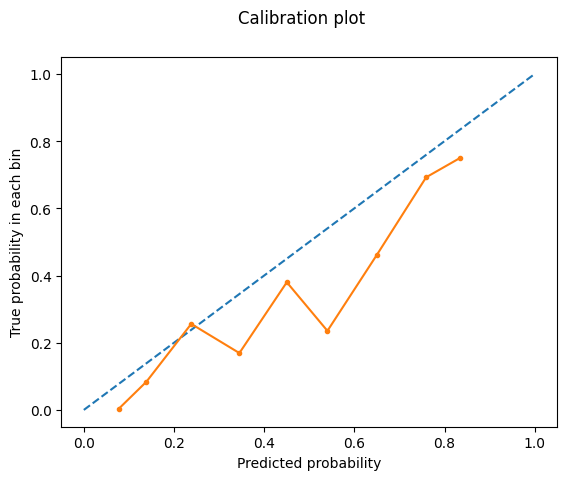

In [ ]:
from sklearn.calibration import calibration_curve

# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
no_zeros = fop > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]
no_zeros = mpv > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]

fig, ax = plt.subplots()
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.show()

You can also check the Brier Score.

$\frac{1}{N}\sum_{i=1}^N{(y_i - \hat{y}_i)^2}$

where:
- $y_i$ is the target to predict (0 or 1).
- $\hat{y}_i$ is the predicted probability of belonging to class 1, P($y_i$=1) .

In [ ]:
from sklearn.metrics import brier_score_loss

In [ ]:
brier_score_loss(y_test, pred_test_p[:, 1])

0.03413652736904864

If probabilities are not calibrated, we can use *CalibratedClassifierCV*

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
?CalibratedClassifierCV

In [ ]:
# [3] Define model
calibrated_model = CalibratedClassifierCV(model,
                                          method = 'isotonic',
                                          cv='prefit')
# [4] Train model
calibrated_model.fit(X_val, y_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=10,
                                               enable_categorical=False,
                                               eval_metric='auc',
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=1000, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None, random_state=1, ...),
                       method='isotonic')

In [ ]:
pred_train_p = calibrated_model.predict_proba(X_train)
pred_val_p = calibrated_model.predict_proba(X_val)
pred_test_p = calibrated_model.predict_proba(X_test)
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:,1]);
auc_val = auc(y_val, pred_val_p[:,1]);
auc_test = auc(y_test, pred_test_p[:,1]);
results = results.append(pd.DataFrame(data={'model':['XGBoost - Calibrated'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)
results

<ipython-input-165-e8b040a2640e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost - Calibrated'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


,model,auc_train,auc_val,auc_test
0,XGBoost - Default,0.961665,0.945823,0.938858
1,XGBoost - Calibrated,0.960756,0.948438,0.938151


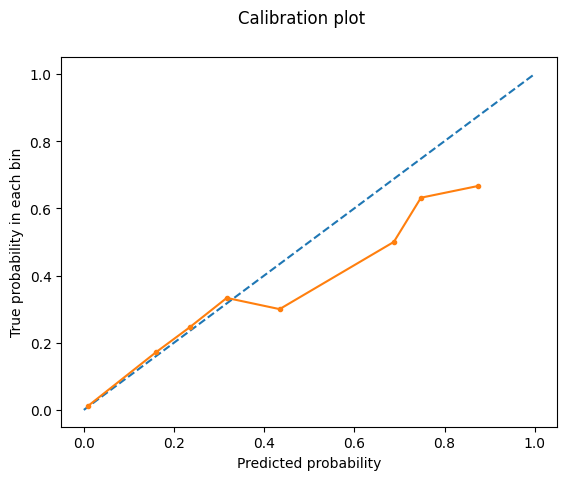

In [ ]:
from sklearn.calibration import calibration_curve

# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
no_zeros = fop > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]
no_zeros = mpv > 0
fop = fop[no_zeros]
mpv = mpv[no_zeros]

fig, ax = plt.subplots()
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')

fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.show()

In [ ]:
brier_score_loss(y_test, pred_test_p[:, 1])

0.02981920754833785

## Grid Search

Let's define the grid we will be using.

In [ ]:
# Xgboost
n_estimators_values = [1000]
learning_rate_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
reg_lambda_values = [0, 1]

params_grid = {'n_estimators': n_estimators_values,
                  'learning_rate': learning_rate_values,
                 'gamma': gamma_values,
                 'max_depth': max_depth_values,
                 'min_child_weight': min_child_weight_values,
                 'subsample': subsample_values,
                 'colsample_bytree': colsample_bytree_values,
                 'num_parallel_tree': num_parallel_tree_values,
                 'reg_lambda': reg_lambda_values}

Get total number of combinations.

In [ ]:
n = len(params_grid['n_estimators'])*len(params_grid['learning_rate'])*len(params_grid['gamma'])*len(params_grid['max_depth'])*len(params_grid['min_child_weight'])*len(params_grid['subsample'])*len(params_grid['colsample_bytree'])*len(params_grid['num_parallel_tree'])*len(params_grid['reg_lambda'])
print(str(n)+ ' iterations of XGBoost')

256 iterations of XGBoost


XGBoost does **parallelization** internally. For that, we have to select the number of threads we want to use. We will select this number automatically.

In [ ]:
from multiprocessing import cpu_count
?cpu_count

In [ ]:
nthread = cpu_count() - 1;
print(nthread);

1


We will be using **AUC** as evaluation metric. This is a multiclass problem so we have to use the *multi_class* argument.

In [ ]:
# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

### Using a Fixed Validation Set

In [ ]:
num_iter = 1;
grid_results = pd.DataFrame(columns = ('n_estimators',
                                       'learning_rate',
                                       'gamma',
                                       'max_depth',
                                       'min_child_weight',
                                       'subsample',
                                       'colsample_bytree',
                                       'num_parallel_tree',
                                       'reg_lambda',
                                       'auc_train',
                                       'auc_val',
                                       'time'))

for n_estimators in params_grid['n_estimators']:
    for learning_rate in params_grid['learning_rate']:
        for gamma in params_grid['gamma']:
            for max_depth in params_grid['max_depth']:
                for min_child_weight in params_grid['min_child_weight']:
                    for subsample in params_grid['subsample']:
                        for colsample_bytree in params_grid['colsample_bytree']:
                            for num_parallel_tree in params_grid['num_parallel_tree']:
                                for reg_lambda in params_grid['reg_lambda']:



                                                # Start time
                                                start_time = default_timer()

                                                # Print trace
                                                print('Iteracion = ' + str(num_iter))

                                                # [3] Define model
                                                model = model_constructor(nthread = nthread,
                                                                      n_estimators = n_estimators,
                                                                      learning_rate = learning_rate,
                                                                      gamma = gamma,
                                                                      max_depth = max_depth,
                                                                      min_child_weight = min_child_weight ,
                                                                      subsample = subsample,
                                                                      colsample_bytree = colsample_bytree,
                                                                      num_parallel_tree = num_parallel_tree,
                                                                      reg_lambda = reg_lambda,
                                                                      early_stopping_rounds = 10,
                                                                      eval_metric = "auc",
                                                                      random_state = 0) # nthread!!!

                                                # [4] Train model
                                                model.fit(X_train, y_train,
                                                          eval_set=[(X_val, y_val)],
                                                          verbose = False)

                                                # [5] Predict
                                                pred_train = model.predict_proba(X_train) # predict_proba!
                                                pred_val = model.predict_proba(X_val) # predict_proba!

                                                # [6] Compute metric
                                                metric_train = metric(y_train, pred_train[:, 1])
                                                metric_val = metric(y_val, pred_val[:, 1])

                                                # Computational time
                                                time = default_timer() - start_time

                                                # print error
                                                print('AUC train = %.2f - AUC validation = %.2f. Time spend = %.2f.'
                                                      % (metric_train, metric_val, time))

                                                # Save iteration results
                                                grid_results.loc[num_iter]=[n_estimators,
                                                                            learning_rate,
                                                                            gamma,
                                                                            max_depth,
                                                                            min_child_weight,
                                                                            subsample,
                                                                            colsample_bytree,
                                                                            num_parallel_tree,
                                                                            reg_lambda,
                                                                            metric_train,
                                                                            metric_val,
                                                                            time]
                                                num_iter += 1

print('Grid Search Total Computational Time: ', np.sum(grid_results.time.values))

Iteracion = 1
AUC train = 0.92 - AUC validation = 0.92. Time spend = 0.50.
Iteracion = 2
AUC train = 0.92 - AUC validation = 0.92. Time spend = 0.49.
Iteracion = 3
AUC train = 0.94 - AUC validation = 0.93. Time spend = 2.76.
Iteracion = 4
AUC train = 0.94 - AUC validation = 0.93. Time spend = 2.78.
Iteracion = 5
AUC train = 0.95 - AUC validation = 0.94. Time spend = 1.03.
Iteracion = 6
AUC train = 0.95 - AUC validation = 0.94. Time spend = 0.97.
Iteracion = 7
AUC train = 0.96 - AUC validation = 0.95. Time spend = 11.71.
Iteracion = 8
AUC train = 0.95 - AUC validation = 0.95. Time spend = 7.03.
Iteracion = 9
AUC train = 0.92 - AUC validation = 0.91. Time spend = 0.42.
Iteracion = 10
AUC train = 0.92 - AUC validation = 0.92. Time spend = 0.38.
Iteracion = 11
AUC train = 0.96 - AUC validation = 0.95. Time spend = 7.94.
Iteracion = 12
AUC train = 0.96 - AUC validation = 0.95. Time spend = 9.90.
Iteracion = 13
AUC train = 0.97 - AUC validation = 0.94. Time spend = 1.41.
Iteracion = 14
AUC t

Check results

In [ ]:
grid_results

,n_estimators,learning_rate,gamma,max_depth,min_child_weight,subsample,colsample_bytree,num_parallel_tree,reg_lambda,auc_train,auc_val,time
1,1000.0,0.30,0.0,6.0,1.0,0.1,0.1,1.0,0.0,0.921504,0.918797,0.499659
2,1000.0,0.30,0.0,6.0,1.0,0.1,0.1,1.0,1.0,0.923692,0.920261,0.486622
3,1000.0,0.30,0.0,6.0,1.0,0.1,0.1,20.0,0.0,0.939067,0.930414,2.762917
4,1000.0,0.30,0.0,6.0,1.0,0.1,0.1,20.0,1.0,0.937306,0.931924,2.777397
5,1000.0,0.30,0.0,6.0,1.0,0.1,1.0,1.0,0.0,0.949086,0.938733,1.034436
...,...,...,...,...,...,...,...,...,...,...,...,...
252,1000.0,0.99,1.0,20.0,20.0,1.0,0.1,20.0,1.0,0.952185,0.946652,3.452647
253,1000.0,0.99,1.0,20.0,20.0,1.0,1.0,1.0,0.0,0.957689,0.942221,1.320571
254,1000.0,0.99,1.0,20.0,20.0,1.0,1.0,1.0,1.0,0.956151,0.938809,1.781444
255,1000.0,0.99,1.0,20.0,20.0,1.0,1.0,20.0,0.0,0.957689,0.942221,20.678007


**Which one is the winner?**

In [ ]:
grid_results = grid_results.sort_values(by = ['auc_val', 'auc_train', 'time'], ascending = [False, False, True])
best_model = grid_results.iloc[0]
best_model

n_estimators         1000.000000
learning_rate           0.990000
gamma                   1.000000
max_depth               6.000000
min_child_weight        1.000000
subsample               1.000000
colsample_bytree        0.100000
num_parallel_tree      20.000000
reg_lambda              1.000000
auc_train               0.959940
auc_val                 0.949089
time                    4.182377
Name: 204, dtype: float64

## Final Model

In [ ]:
# [3] Define model
model = model_constructor(nthread = nthread,
                          n_estimators = int(best_model.n_estimators),
                          learning_rate = best_model.learning_rate,
                          gamma = best_model.gamma,
                          max_depth = int(best_model.max_depth),
                          min_child_weight = best_model.min_child_weight ,
                          subsample = best_model.subsample,
                          colsample_bytree = best_model.colsample_bytree,
                          num_parallel_tree = int(best_model.num_parallel_tree),
                          reg_lambda = best_model.reg_lambda,
                          early_stopping_rounds = 10,
                          eval_metric = 'auc',
                          random_state = 0) # Use same random_state as in training!!!

# [4] Train model
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose = True)

[0]	validation_0-auc:0.91269
[1]	validation_0-auc:0.93810
[2]	validation_0-auc:0.94269
[3]	validation_0-auc:0.93607
[4]	validation_0-auc:0.94088
[5]	validation_0-auc:0.94169
[6]	validation_0-auc:0.94220
[7]	validation_0-auc:0.94207
[8]	validation_0-auc:0.94344
[9]	validation_0-auc:0.94541
[10]	validation_0-auc:0.94664
[11]	validation_0-auc:0.94751
[12]	validation_0-auc:0.94791
[13]	validation_0-auc:0.94841
[14]	validation_0-auc:0.94891
[15]	validation_0-auc:0.94906
[16]	validation_0-auc:0.94909
[17]	validation_0-auc:0.94885
[18]	validation_0-auc:0.94866
[19]	validation_0-auc:0.94875
[20]	validation_0-auc:0.94892
[21]	validation_0-auc:0.94873
[22]	validation_0-auc:0.94869
[23]	validation_0-auc:0.94891
[24]	validation_0-auc:0.94894
[25]	validation_0-auc:0.94885
[26]	validation_0-auc:0.94858


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.99, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=1, num_parallel_tree=20,
              predictor=None, ...)

In [ ]:
pred_train_p = model.predict_proba(X_train)
pred_val_p = model.predict_proba(X_val)
pred_test_p = model.predict_proba(X_test)
# Calcular métricas de evaluación
auc_train = auc(y_train, pred_train_p[:,1]);
auc_val = auc(y_val, pred_val_p[:,1]);
auc_test = auc(y_test, pred_test_p[:,1]);
results = results.append(pd.DataFrame(data={'model':['XGBoost - Optimized'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)
results

<ipython-input-177-f62d804895e9>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data={'model':['XGBoost - Optimized'],'auc_train':[auc_train],'auc_val':[auc_val],'auc_test':[auc_test]}, columns=['model',  'auc_train','auc_val', 'auc_test']), ignore_index=True)


,model,auc_train,auc_val,auc_test
0,XGBoost - Default,0.961665,0.945823,0.938858
1,XGBoost - Calibrated,0.960756,0.948438,0.938151
2,XGBoost - Optimized,0.959940,0.949089,0.935218
